# Instance creator utility

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.io import loadmat
import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '12'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams["errorbar.capsize"] = 2.

sys.path.append('..')
from models.Fleet import *
from models.Fleet import from_xml as fleet_from_xml
from models.Network import *

## Standard travel time and energy consumption profile

In [2]:
def edge_data(data, i, j, t):
    soc_data = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['soc'][0]*24
    tt_data  = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['time'][0]/60
    soc_mean, tt_mean = np.mean(soc_data), np.mean(tt_data)
    soc_std, tt_std = np.std(soc_data), np.std(tt_data)    
    return (soc_mean, tt_mean), (soc_std, tt_std)

path = '../data/real_data/data_21nodes_fixed.mat'
data = loadmat(path)

network_size = len(data['starting_time'][0][0]['origin'][0])
data_points = len(data['starting_time'][0])

soc_matrix, tt_matrix = np.zeros((1, data_points)), np.zeros((1, data_points))
samples = 0

for i in range(network_size):
    for j in range(network_size):
        if i != j:
            (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, 0)
            dij = 35*tt_mean/60.  # km
            if dij == .0:
                continue
            soc_array, tt_array = np.zeros((1, data_points)), np.zeros((1, data_points))
            for t in range(data_points):
                (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, t)
                v = 60*dij/tt_mean  # km/h
                t1km = 60/v  # min
                E1km = soc_mean/dij
                tt_array[0, t] = t1km
                soc_array[0, t] = E1km
            soc_matrix = np.append(soc_matrix, soc_array, axis = 0)
            tt_matrix = np.append(tt_matrix, tt_array, axis = 0)


In [3]:
tt_mean = np.mean(tt_matrix, axis=0)
ec_mean = np.mean(soc_matrix, axis=0)

tt_std = np.std(tt_matrix, axis=0)
ec_std = np.std(soc_matrix, axis=0)

time_day = range(data_points)

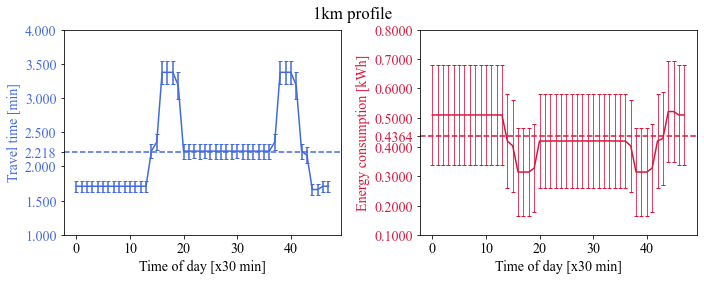

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle(f'1km profile')

color = 'royalblue'
tt_mean_global = np.mean(tt_mean)
ax1.errorbar(time_day, tt_mean, tt_std, color=color)
ax1.axhline(tt_mean_global, color=color, linestyle='--')
ax1.set_xlabel('Time of day [x30 min]')
ax1.set_ylabel('Travel time [min]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(list(ax1.get_yticks()) + [tt_mean_global])

color = 'crimson'
ec_mean_global = np.mean(ec_mean)
ax2.errorbar(time_day, ec_mean, ec_std, color=color, elinewidth=.8)
ax2.axhline(ec_mean_global, color=color, linestyle='--')
ax2.set_xlabel('Time of day [x30 min]')
ax2.set_ylabel('Energy consumption [kWh]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(list(ax2.get_yticks()) + [ec_mean_global])

fig.tight_layout()
fig.subplots_adjust(top=0.9)

## Create network

### Network params

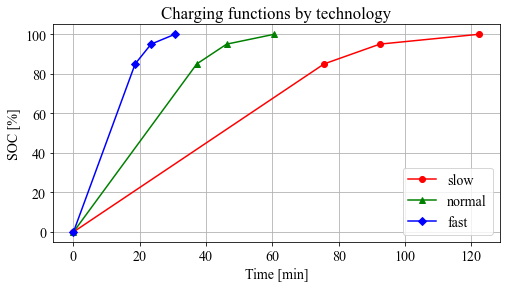

In [25]:
n_customers = 80
n_charg_sta = 10
minx, maxx = -15, 15 # km
miny, maxy = -15, 15 # km
minreq, maxreq = 0.01, 0.08
mintime, maxtime = 8, 15
mintw_low, maxtw_low = 60*9, 60*15
mintw_width, maxtw_width = 60*2.5, 60*3.5
cs_capacity = 2

# CS technologies
tech1 = {0.0: 0.0, 75.6: 85.0, 92.4: 95.0, 122.4: 100.0} # slow
tech2 = {0.0: 0.0, 37.2: 85.0, 46.2: 95.0, 60.6: 100.0}  # normal
tech3 = {0.0: 0.0, 18.6: 85.0, 23.4: 95.0, 30.6: 100.0}  # fast
tech_list = [tech1, tech2, tech3]
tech_price = [70., 70.*1.5, 70.*2.5]

# Plot charging functions
fig = plt.figure(figsize=(8,4))
style_list = [('slow', '-ro'), ('normal', '-g^'), ('fast', '-bD')]
for tech, (label, style) in zip(tech_list, style_list):
    t = list(tech.keys())
    soc = list(tech.values())
    plt.plot(t, soc, style, label=label)
    
plt.xlabel('Time [min]')
plt.ylabel('SOC [%]')
plt.title('Charging functions by technology')
plt.grid()    
plt.legend()
plt.show()    
fig.savefig('../pictures/chargingFunctions.pdf')

### Instance network

(<Figure size 432x288 with 1 Axes>,
 <networkx.classes.digraph.DiGraph at 0x249a6da6d08>)

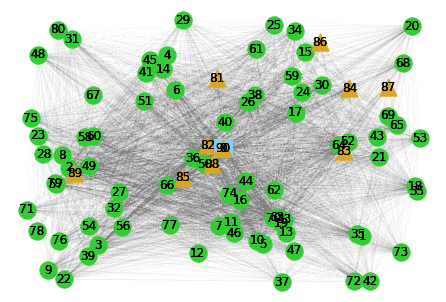

In [6]:
# Dictionaries with nodes and edges
nodes = {}
edges = {}

for i in range(1 + n_customers + n_charg_sta):
    cx = float('{:.2f}'.format(np.random.uniform(minx, maxx)))
    cy = float('{:.2f}'.format(np.random.uniform(miny, maxy)))
    
    # Depot
    if i == 0:
        node = DepotNode(0, 0, 0, 0, 0)

    # Customers
    elif 1 <= i < 1 + n_customers:
        spent_time = float('{:.2f}'.format(np.random.uniform(mintime, maxtime)))
        demand = float('{:.2f}'.format(np.random.uniform(minreq, maxreq)))
        tw_low = float('{:.2f}'.format(np.random.uniform(mintw_low, maxtw_low)))
        tw_upp = float('{:.2f}'.format(tw_low + np.random.uniform(mintw_width, maxtw_width)))
        node = CustomerNode(i, spent_time, demand, cx, cy, tw_low, tw_upp)

    # Charging Stations
    elif 1 <= i < n_customers + n_charg_sta:
            j = np.random.randint(3)
            time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
            node = ChargeStationNode(i, 0, 0, cx, cy, cs_capacity, time_points, soc_points, 
                                     j + 1, tech_price[j])
    # Charging station at depot
    else:
        j = np.random.randint(3)
        time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
        node = ChargeStationNode(i, 0, 0, 0, 0, cs_capacity, time_points, soc_points, 
                                 j + 1, tech_price[j])
        
    nodes[i] = node

# Edges
for i in range(1 + n_customers + n_charg_sta):
    edges[i] = {}
    for j in range(1 + n_customers + n_charg_sta):
        a, b = nodes[i], nodes[j]
        dist = np.sqrt((a.pos_x-b.pos_x)**2 + (a.pos_y-b.pos_y)**2)
        tAB = dist*tt_mean + np.random.normal(0, tt_std) if dist > 0. else dist*tt_mean/60.
        eAB = dist*ec_mean + np.random.normal(0, ec_std) if dist > 0. else dist*ec_mean
        edge = DynamicEdge(i, j, 30., tAB, eAB, dist)
        edges[i][j] = edge

# Instance network
network = Network(nodes, edges)
network.draw(save_to=None, width=0.003, edge_color='grey', markeredgecolor='black', markeredgewidth=2.0)

## Create fleet

### Fleet params

In [7]:
ev_id = 0
alpha_down, alpha_upp = 0, 100
battery_capacity = 24  # kWh
battery_capacity_nominal = battery_capacity
max_payload = 0.553 # tonnes
weight = 1.52  # tonnes
max_tour_duration = 6*60.

### Instance fleet

In [8]:
ev = ElectricVehicle(ev_id, weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, max_payload)
fleet = Fleet({0: ev}, network)

### Save fleet

In [9]:
fleet.write_xml('test.xml', True, print_pretty=True)

# Creation of dataset

### Specify dataset sizes and variants

In [15]:
i10 = [(10, i) for i in [1, 2]]
i25 = [(25, i) for i in [3]]
i50 = [(50, i) for i in [5]]
i75 = [(75, i) for i in [10, 15]]
i100 = [(100, i) for i in [15, 20]]
description = i25 + i50

### Iterate

In [21]:
for (n_customers, n_charg_sta) in description:
    # Dictionaries with nodes and edges
    nodes = {}
    edges = {}

    for i in range(1 + n_customers + n_charg_sta):
        cx = float('{:.2f}'.format(np.random.uniform(minx, maxx)))
        cy = float('{:.2f}'.format(np.random.uniform(miny, maxy)))

        # Depot
        if i == 0:
            node = DepotNode(0, 0, 0, 0, 0)

        # Customers
        elif 1 <= i < 1 + n_customers:
            spent_time = float('{:.2f}'.format(np.random.uniform(mintime, maxtime)))
            demand = float('{:.2f}'.format(np.random.uniform(minreq, maxreq)))
            tw_low = float('{:.2f}'.format(np.random.uniform(mintw_low, maxtw_low)))
            tw_upp = float('{:.2f}'.format(tw_low + np.random.uniform(mintw_width, maxtw_width)))
            node = CustomerNode(i, spent_time, demand, cx, cy, tw_low, tw_upp)

        # Charging Stations
        elif 1 <= i < n_customers + n_charg_sta:
            #j = np.random.randint(3)
            j = 0
            time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
            node = ChargeStationNode(i, 0, 0, cx, cy, cs_capacity, time_points, soc_points, 
                                     j + 1, tech_price[j])
        # Charging station at depot
        else:
            #j = np.random.randint(3)
            j = 0
            time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
            node = ChargeStationNode(i, 0, 0, 0, 0, cs_capacity, time_points, soc_points, 
                                     j + 1, tech_price[j])

        nodes[i] = node

    # Edges
    for i in range(1 + n_customers + n_charg_sta):
        edges[i] = {}
        for j in range(1 + n_customers + n_charg_sta):
            a, b = nodes[i], nodes[j]
            dist = np.sqrt((a.pos_x-b.pos_x)**2 + (a.pos_y-b.pos_y)**2)
            tAB = dist*tt_mean + np.random.normal(0, tt_std/10.) if dist > 0. else 0.*tt_mean
            eAB = dist*ec_mean + np.random.normal(0, ec_std/10.) if dist > 0. else 0.*ec_mean
            edge = DynamicEdge(i, j, 30., tAB, eAB, dist)
            edges[i][j] = edge

    # Instance network
    network = Network(nodes, edges)

    # Fleet
    ev = ElectricVehicle(ev_id, weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, max_payload)
    fleet = Fleet({0: ev}, network)

    # Save
    path = f'../data/instances/c{n_customers}cs{n_charg_sta}_{maxx-minx}x{maxy-miny}km.xml'
    fleet.write_xml(path, True)

In [12]:
fleet = fleet_from_xml('../data/instances/c10cs1_40x40km.xml')
network = fleet.network
i, j = 0, 5
print(network.edges[i][j].distance)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(network.edges[i][j].travel_time)
ax2.plot(network.edges[i][j].energy_consumption)

FileNotFoundError: [Errno 2] No such file or directory: '../data/instances/c10cs1_40x40km.xml'

In [ ]:
tt_mean